<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Random Forest Regression 
</p>

In [29]:
# Libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from sklearn.model_selection import PredefinedSplit

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Dataset: Load Splits 
</p>

In [30]:
# Path to the standardized database directory
base_path = '../../Comprehensive ML - Files & Plots etc.'

# Load train and test splits
df_train = pd.read_csv(f"{base_path}/train.csv")
df_test = pd.read_csv(f"{base_path}/test.csv")

feature_names = [
    'distance', 'frequency', 'c_walls', 'w_walls', 'co2', 'humidity', 
    'pm25', 'pressure', 'temperature', 'snr'
]

X_train = df_train[feature_names].values
y_train = df_train['PL'].values
X_test = df_test[feature_names].values
y_test = df_test['PL'].values

# (Should we need them for plotting)
time_train = df_train['time'].values
time_test = df_test['time'].values

# Load 5-fold assignments
fold_assignments = np.load(f"{base_path}/train_folds.npy")

print(f"\nTraining samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
unique, counts = np.unique(fold_assignments, return_counts=True)
print(dict(zip(unique, counts)))
print('\nDataset loaded successfully!\n')


Training samples: 1132523, Test samples: 283131
{np.int64(0): np.int64(226505), np.int64(1): np.int64(226505), np.int64(2): np.int64(226505), np.int64(3): np.int64(226504), np.int64(4): np.int64(226504)}

Dataset loaded successfully!



<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Define Bayesian Search Space and Model Helper
</p>

In [31]:
# Our param space for Bayesian optimization
search_spaces = {
    'n_estimators': Integer(100, 300),
    'max_depth': Integer(3, 9), # [3, 4, ..., 9]
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 500)
}

def create_rf_model():
    return RandomForestRegressor(
        criterion='squared_error',
        max_features='log2',
        random_state=50,
        n_jobs=-1,
        min_impurity_decrease=0.01,
        bootstrap=True,
        oob_score=False
    )

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Bayesian SearchCV with Custom Folds & Analysis Per-Depth Results 
</p>

In [32]:
# ---- Setup for multi-metric scoring ----
scoring = {
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

# ---- Create your PredefinedSplit (you already have fold_assignments) ----
ps = PredefinedSplit(fold_assignments)

# ---- Bayesian optimization, scoring on both RMSE and R² ----
bayes_cv = BayesSearchCV(
    estimator=create_rf_model(),  # your function for RF config
    search_spaces=search_spaces,
    n_iter=20,  # or as desired
    scoring=scoring,
    refit='neg_root_mean_squared_error',  # selects best by RMSE
    n_jobs=-1,
    cv=ps,
    random_state=42,
    verbose=2
)

# Suppress skopt UserWarnings about repeated evaluation of the same hyperparameter set
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='skopt')

print(f"Starting Bayesian optimization with {bayes_cv.n_iter} iterations "
      f"and {ps.get_n_splits()}-fold cross-validation per candidate...")

# ---- Fit Bayesian optimizer on training data ----
bayes_cv.fit(X_train, y_train) 

print("Bayesian optimization complete. Extracting results...")

# ---- Pull all tried configs/results into a dataframe ----
bayes_results = pd.DataFrame(bayes_cv.cv_results_)

# ---- For each max_depth, track best results for plotting ----
cv_summary_per_depth = []
for max_depth in range(2, 10):
    mask = bayes_results['param_max_depth'] == max_depth
    df_depth = bayes_results[mask]
    if not df_depth.empty:
        # Find best (highest) mean_test_neg_root_mean_squared_error (less negative = better)
        idx = df_depth['mean_test_neg_root_mean_squared_error'].idxmax()
        best_row = df_depth.loc[idx]
        best_rmse = -best_row['mean_test_neg_root_mean_squared_error']
        std_rmse = best_row['std_test_neg_root_mean_squared_error']
        best_cv_r2 = best_row['mean_test_r2']
        std_cv_r2 = best_row['std_test_r2']
        best_params = {k.split('param_')[1]: best_row[k] for k in bayes_results.columns if k.startswith('param_')}
        print(f"Best Params for max_depth={max_depth}: {best_params}")
        print(f"Best CV RMSE for max_depth={max_depth}: {best_rmse:.4f}")
        print(f"STD of CV RMSE for max_depth={max_depth}: {std_rmse:.4f}")
        print(f"Best CV R² for max_depth={max_depth}: {best_cv_r2:.4f}")
        print(f"STD of CV R² for max_depth={max_depth}: {std_cv_r2:.4f}")
        cv_summary_per_depth.append({
            'max_depth': max_depth,
            'best_cv_rmse': best_rmse,
            'std_cv_rmse': std_rmse,
            'best_cv_r2': best_cv_r2,
            'std_cv_r2': std_cv_r2,
            'best_params': best_params
        })

cv_df = pd.DataFrame(cv_summary_per_depth)

Starting Bayesian optimization with 20 iterations and 5-fold cross-validation per candidate...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for 

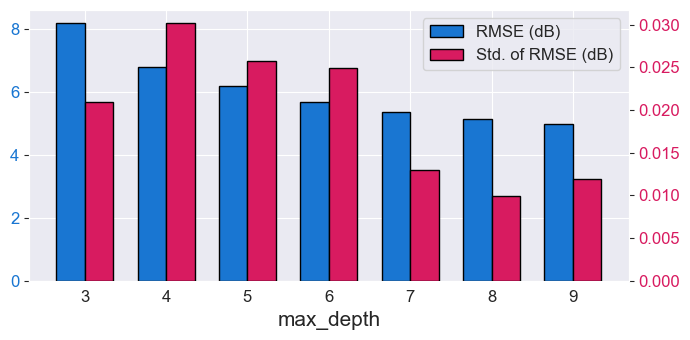

In [33]:
# ---- FONT SIZE METRICS ----
tick_fontsize = 12         # Tick label size
axis_labelsize = 15        # Axis label size
legend_fontsize = 12       # Legend font size

# ---- GLOBAL FONT FAMILY: Times New Roman ----
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

sns.set_style("darkgrid")

x = np.arange(len(cv_df['max_depth']))
bar_width = 0.35

fig, ax1 = plt.subplots(figsize=(7, 3.5))

# Blue bars: Best CV RMSE (left y-axis)
bars1 = ax1.bar(
    x - bar_width/2, 
    cv_df['best_cv_rmse'], 
    bar_width, 
    color='#1976d2',
    label='RMSE',
    edgecolor='black',
    linewidth=1,
    zorder=3
)
#ax1.set_ylabel('RMSE (dB)', color='#1976d2', fontsize=axis_labelsize)
ax1.set_xlabel('max_depth', fontsize=axis_labelsize)
ax1.set_xticks(x)
ax1.set_xticklabels(cv_df['max_depth'], fontsize=tick_fontsize)
ax1.tick_params(axis='y', labelcolor='#1976d2', labelsize=tick_fontsize)
ax1.grid(True, axis='y')

# Magenta bars: STD of CV RMSE (right y-axis), offset to right
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + bar_width/2, 
    cv_df['std_cv_rmse'], 
    bar_width, 
    color='#d81b60',
    label='Std. of RMSE',
    edgecolor='black',
    linewidth=1,
    zorder=3
)
#ax2.set_ylabel('Std. of RMSE (dB)', color='#d81b60', fontsize=axis_labelsize)
ax2.tick_params(axis='y', labelcolor='#d81b60', labelsize=tick_fontsize)
ax2.grid(False)

# Single legend
handles = [
    plt.Rectangle((0,0),1,1,color='#1976d2',ec='black',label='RMSE (dB)'),
    plt.Rectangle((0,0),1,1,color='#d81b60',ec='black',label='Std. of RMSE (dB)')
]
ax1.legend(handles=handles, loc='upper right', fontsize=legend_fontsize)

fig.tight_layout()
plt.savefig('../../Comprehensive ML - Files & Plots etc/RF_bestRMSE_&_STD_perDepth.png', dpi=2000, bbox_inches='tight')
plt.show()

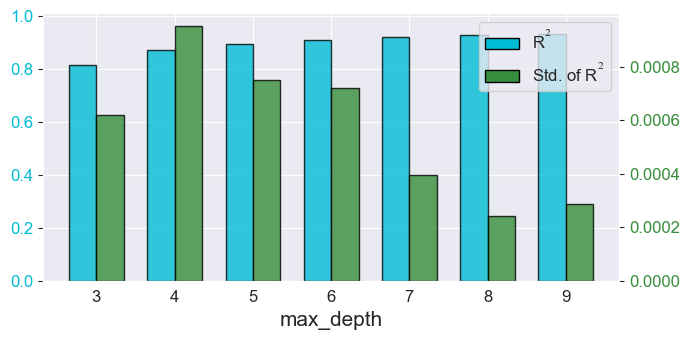

In [34]:
# ---- FONT SIZE METRICS ----
tick_fontsize = 12         # Tick label size
axis_labelsize = 15        # Axis label size
legend_fontsize = 12       # Legend font size

# ---- GLOBAL FONT FAMILY: Times New Roman ----
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

sns.set_style("darkgrid")

x = np.arange(len(cv_df['max_depth']))
bar_width = 0.35

fig, ax1 = plt.subplots(figsize=(7, 3.5))

# --- Cyan bars: Best CV R² (left y-axis) ---
bars1 = ax1.bar(
    x - bar_width/2, 
    cv_df['best_cv_r2'], 
    bar_width, 
    color='#00bcd4',                # Cyan
    edgecolor='black',
    linewidth=1,
    alpha=0.8,
    label='R$^2$'
)
ax1.set_xlabel('max_depth', fontsize=axis_labelsize)
#ax1.set_ylabel('Best CV R$^2$', color='#00bcd4', fontsize=axis_labelsize)
ax1.set_xticks(x)
ax1.set_xticklabels(cv_df['max_depth'], fontsize=tick_fontsize)
ax1.tick_params(axis='y', labelcolor='#00bcd4', labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)
ax1.set_ylim(0, 1.01)
ax1.grid(True, axis='y')

# --- Green bars: STD of CV R² (right y-axis) ---
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + bar_width/2, 
    cv_df['std_cv_r2'], 
    bar_width, 
    color='#388e3c',                # Green
    edgecolor='black',
    linewidth=1,
    alpha=0.8,
    label='Std. of R$^2$'
)
#ax2.set_ylabel('Std. of CV R$^2$', color='#388e3c', fontsize=axis_labelsize)
ax2.tick_params(axis='y', labelcolor='#388e3c', labelsize=tick_fontsize)
ax2.grid(False)

# --- Combined Legend (top right, inside) ---
handles = [
    plt.Rectangle((0,0),1,1,color='#00bcd4',ec='black',label='R$^2$'),
    plt.Rectangle((0,0),1,1,color='#388e3c',ec='black',label='Std. of R$^2$')
]
ax1.legend(handles=handles, loc='upper right', fontsize=legend_fontsize)

fig.tight_layout()
#plt.savefig('../../Comprehensive ML - Files & Plots etc/RF_bestR2_STD_perDepth.png', dpi=2000, bbox_inches='tight')
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Train on All Training Data and Test Evaluation 
</p>

In [35]:
best_idx = bayes_results['mean_test_neg_root_mean_squared_error'].idxmax()  # BayesSearchCV maximizes (less negative = better)
best_params = {k.split('param_')[1]: bayes_results.loc[best_idx, k] for k in bayes_results.columns if k.startswith('param_')}
print("Best Parameters Found:", best_params)

rf_model = RandomForestRegressor(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    criterion='squared_error',
    max_features='log2',
    random_state=50,
    n_jobs=-1,
    min_impurity_decrease=0.01,
    bootstrap=True,
    oob_score=False
)
print("\nTraining Random Forest model on all training data...")
rf_model.fit(X_train, y_train)
print("\nTraining Completed!\n")

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_median_ae = median_absolute_error(y_test, y_test_pred)

results = pd.DataFrame({
    'Metric': [
        'Training Loss (MSE)', 'Test Loss (MSE)', 'Test RMSE',
        'R² Score (Test)', 'Test MAPE (%)', 'Test Median AE'
    ],
    'Value': [
        train_mse, test_mse, test_rmse, test_r2,
        test_mape * 100, test_median_ae
    ]
})

print("\nModel Evaluation Metrics:")
display(results)

Best Parameters Found: {'max_depth': np.int64(9), 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(54), 'n_estimators': np.int64(300)}

Training Random Forest model on all training data...

Training Completed!


Model Evaluation Metrics:


,Metric,Value
0,Training Loss (MSE),24.944825
1,Test Loss (MSE),24.880993
2,Test RMSE,4.988085
3,R² Score (Test),0.931430
4,Test MAPE (%),4.382226
5,Test Median AE,3.032834
